# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [3]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import sys
import json
import re
import glob

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import gc
from sklearn.preprocessing import LabelBinarizer

# Import python files
sys.path.append("../utils/")  # This adds the scripts folder to the path
import preprocess
import plotter

## 1. Dataset

## Train Diffusion Model

### Sampling

In [53]:
# Algorithm 2: Sampling
# =====================================================================
def sampling(
    model: tf.keras.models.Model,
    start_noise: np.ndarray,
    T: int = T,
    scheduler: str = "linear",
    beta_start: float = beta_start,
    beta_end: float = beta_end,
) -> np.ndarray:
    """
    Samples an image from the model.

    :param model: The model to sample from.
    :param start_noise: The noise to start the sampling from.
    :param T: The number of timesteps to sample for.
    :param scheduler: The type of schedule to use. Options are "linear" or "cosine".
    :param beta_start: Starting value of beta.
    :param beta_end: Ending value of beta.
    :return: The sampled image.
    """

    # Get the beta schedule and corresponding alpha values
    beta = beta_scheduler(scheduler, T, beta_start, beta_end)
    alpha = 1.0 - beta
    alpha_cumprod = np.cumprod(alpha)

    # Set the starting noise
    x_t = start_noise  # 1: x_T ~ N(0, I)

    # Reverse the diffusion process
    for t in tqdm(
        reversed(range(1, T)), desc="Sampling", total=T - 1, leave=False
    ):  # 2: for t = T − 1, . . . , 1 do
        # Compute normalized timestep
        normalized_t = np.array([t / T]).reshape(1, -1).astype("float32")
        # Sample z_t
        z = (
            np.random.normal(size=x_t.shape)
            if t > 1
            else np.zeros(x_t.shape).astype("float32")
        )  # 3: z ∼ N(0, I) if t > 1, else z = 0
        # Calculate x_(t-1)
        predicted_noise = model.predict(
            [x_t, normalized_t], verbose=0
        )  # Predict the noise estimate using the model = eps_theta
        x_t = (
            x_t - (1 - alpha[t]) / np.sqrt(1 - alpha_cumprod[t]) * predicted_noise
        ) / np.sqrt(alpha[t]) + np.sqrt(
            beta[t]
        ) * z  # 4: x_(t-1) = (x_t - (1 - alpha_t) / sqrt(1 - alpha_cumprod_t) * eps_theta) / sqrt(alpha_t) + sigma_t * z

    # Return the final sample
    return x_t  # 5: return x_0

Las funciones auxiliares proporcionadas cumplen roles importantes para la evaluación y visualización del modelo de difusión:

- ``generate_em()``: Esta función crea una etiqueta aleatoria para condicionar el modelo de difusión. Genera un vector de ceros de longitud num_classes y asigna el valor 1 en una posición aleatoria dentro del vector.

- ``plot_samples()``: visualiza muestras generadas por el modelo de difusión a partir de las funciones mencionadas anteriormente.

In [54]:
# Auxiliary functions
# =====================================================================


# Generate a random embedding (label) =====================================================================
def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
    """
    Generates a random embedding (label)

    :param num_classes: The number of classes
    """

    em = np.zeros(num_classes)
    em[np.random.randint(0, num_classes - 1)] = 1
    return em


# Plot samples function =====================================================================
def plot_samples(
    model: tf.keras.models.Model,
    num_samples: int = 2,
    T: int = T,
    scheduler: str = "linear",
    beta_start: float = beta_start,
    beta_end: float = beta_end,
) -> None:
    """
    Plots samples from the model.

    :param model: The model to sample from.
    :param num_samples: The number of samples to plot.
    :param T: The number of timesteps to sample for.
    :param scheduler: The type of schedule to use. Options are "linear" or "cosine".
    :return: The sampled image.
    """

    fig, axs = plt.subplots(
        1, num_samples, figsize=(num_samples * 2, 2)
    )  # Creating a row of subplots

    for i in trange(num_samples, desc="Sample plot", leave=True):
        start_noise = np.random.normal(size=(1, IMG_SIZE, IMG_SIZE, 3)).astype(
            "float32"
        )
        y_label = generate_em().reshape(
            1, 18
        )  # reshape to (1,18) to match the model input
        sample = sampling(
            model, start_noise, y_label, T, scheduler, beta_start, beta_end
        )
        sample = (sample + 1.0) / 2.0  # Scale to [0, 1]
        axs[i].imshow(sample[0])
        axs[i].title.set_text(
            onehot_to_string(y_label[0])
        )  # use the onehot_to_string function described above
        axs[i].axis("off")

    plt.show()

### Training

In [55]:
# Algorithm 1: Training
# =====================================================================
def training(
    model: tf.keras.models.Model,
    dataset: tf.data.Dataset,
    optimizer: tf.keras.optimizers.Optimizer,
    loss_fn: tf.keras.losses.Loss,
    total_epochs: int = 10,
    scheduler: str = "cosine",
    T: int = 100,
) -> None:
    """
    Performs the training loop.

    :param model: The model to train.
    :param dataset: The training dataset.
    :param optimizer: The optimizer to use.
    :param loss_fn: The loss function to use.
    :param total_epochs: The number of epochs to train for.
    :param scheduler: The type of schedule to use. Options are "linear" or "cosine".
    :param T: The number of timesteps to sample for.
    :return: None
    """

    # Get scheduler values
    beta = beta_scheduler(scheduler, T, beta_start, beta_end)  # Get beta
    alpha = 1.0 - beta  # Get alpha
    alpha_cumprod = np.cumprod(alpha)  # Get alpha cumulative product

    for epoch in trange(
        prev_epoch,
        total_epochs,
        desc=f"Training",
        total=total_epochs - prev_epoch,
        leave=True,
    ):  # 1: repeat (iterations through the epochs)
        for step, input_data in tqdm(
            enumerate(dataset),
            desc=f"Epoch {epoch+1}/{total_epochs}",
            total=len(dataset),
            leave=True,
        ):  # 1: repeat (iterations through the batches)
            # Generate a single timestep for one entire batch
            t = np.random.randint(0, T)
            normalized_t = np.full(
                (input_data.shape[0], 1), t / T, dtype=np.float32
            )  # 3: t ~ U(0, T)

            # Get the target noise
            noised_data = forward_diffusion(input_data, t, scheduler)  # 2: x_0 ~ q(x_0)
            target_noise = noised_data - input_data * np.sqrt(
                alpha_cumprod[t]
            )  # 4: eps_t ~ N(0, I)

            # 5: Take a gradient descent step on
            with tf.GradientTape() as tape:
                predicted_noise = model(
                    [noised_data, normalized_t], training=True
                )  # eps_theta -> model(x_t, t/T)
                loss = loss_fn(
                    target_noise, predicted_noise
                )  # gradient of the loss (MSE(eps_t, eps_theta))
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # if step % 2 == 0:
            #     plt.subplot(1,3,1)
            #     plt.imshow(input_data[0])
            #     plt.title('input')
            #     plt.subplot(1,3,2)
            #     plt.imshow(noised_data[0])
            #     plt.title('noised')
            #     plt.subplot(1,3,3)
            #     plt.imshow(target_noise[0])
            #     plt.title('target')
            #     plt.show()

            # f, axis = plt.subplots(1, 2, figsize=(10, 5))
            # axis[0].imshow(target_noise[0]*0.5+0.5)
            # axis[0].set_title('target noise')
            # axis[1].imshow(predicted_noise[0]*0.5+0.5)
            # axis[1].set_title('predicted noise')
            # plt.show()

        print(f"EPOCH {epoch+1} LOSS: {loss.numpy():.4f} \n{'='*69}")

        # # Save the model and it's weights at the end of every 20 epochs
        # if (epoch+1) % 20 == 0:
        #     print(f"\tSaving model and its _weights in epoch {epoch+1}")
        #     model.save(f'{folder_epoch}/diffusion_{scheduler}_{epoch+1}.h5')
        #     model.save_weights(f'{folder_epoch}/weights{scheduler}_{epoch+1}.h5')

        # Sample and plot every 10 epochs
        if (epoch + 1) % 10 == 0:
            print("\tSampling images...")
            plot_samples(model, num_samples=3, scheduler=scheduler, T=T)

## Forzar overfitting

In [114]:
df = preprocess.load_csv("../../dataset/pokedex.csv")
data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
data_dict = preprocess.dataset_dict(data_path, df)
dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
label_mappping = preprocess.create_label_mapping(df)

File ../../dataset/image_paths.json loaded successfully!
- Number of paths: 8143


<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


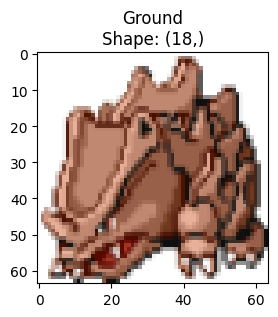

In [138]:
# get only one image of the dataset
dataset_example = dataset.take(1)

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(32).batch(32)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    plotter.plot_batch_images(img, label, label_mappping, 1)

In [139]:
def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
    """Generates a random embedding (label)

    :param num_classes: The number of classes
    """

    em = np.zeros(num_classes)
    em[np.where(label_example[0] == 1)[0][0]] = 1
    return em


generate_em()
plotter.onehot_to_string(generate_em(), label_mappping)

'Ground'

In [140]:
# Train the model
# =====================================================================
training(
    model=model,
    dataset=dataset_example,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scheduler=scheduler,
    T=T,
    total_epochs=EPOCHS,
)

No checkpoints found, starting training from scratch...


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]

AttributeError: 'tuple' object has no attribute 'shape'

### Plot Results

Sample plot:   0%|          | 0/2 [00:00<?, ?it/s]

TypeError: sampling() takes from 2 to 6 positional arguments but 7 were given

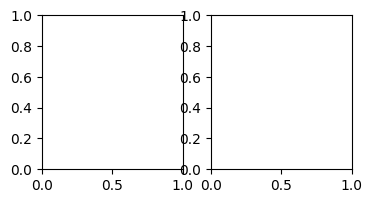

In [127]:
# Plor samples of the trained model
# =====================================================================
plot_samples(model=model, num_samples=2, scheduler=scheduler)